# Taller 2.4 - Transformaciones Homogéneas y Cambios de Base

In [1]:
%%capture

%pip install numpy matplotlib pillow

In [2]:
from __future__ import annotations

from pathlib import Path
from typing import Iterable

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML, display

np.set_printoptions(precision=4, suppress=True)
plt.style.use('seaborn-v0_8-whitegrid')

MEDIA_DIR = (Path.cwd() / '../media').resolve()
MEDIA_DIR.mkdir(parents=True, exist_ok=True)


def save_figure(fig: plt.Figure, suffix: str) -> Path:
    out_path = MEDIA_DIR / f'python_{suffix}.png'
    fig.savefig(out_path, dpi=200, bbox_inches='tight')
    return out_path

## 1) Coordenadas homogéneas en 2D

In [3]:
def to_homogeneous_2d(points: np.ndarray) -> np.ndarray:
    points = np.asarray(points, dtype=float)
    if points.ndim != 2 or points.shape[1] != 2:
        raise ValueError('Se esperaba un arreglo de forma (N, 2).')
    return np.hstack([points, np.ones((points.shape[0], 1), dtype=float)])


def from_homogeneous_2d(points_h: np.ndarray) -> np.ndarray:
    points_h = np.asarray(points_h, dtype=float)
    if points_h.ndim != 2 or points_h.shape[1] != 3:
        raise ValueError('Se esperaba un arreglo de forma (N, 3).')
    w = points_h[:, [2]]
    if np.any(np.isclose(w, 0.0)):
        raise ValueError('No se puede dividir por w=0.')
    return points_h[:, :2] / w


def translation_2d(tx: float, ty: float) -> np.ndarray:
    return np.array([[1.0, 0.0, tx], [0.0, 1.0, ty], [0.0, 0.0, 1.0]])


def rotation_2d(theta_rad: float) -> np.ndarray:
    c, s = np.cos(theta_rad), np.sin(theta_rad)
    return np.array([[c, -s, 0.0], [s, c, 0.0], [0.0, 0.0, 1.0]])


def scaling_2d(sx: float, sy: float) -> np.ndarray:
    return np.array([[sx, 0.0, 0.0], [0.0, sy, 0.0], [0.0, 0.0, 1.0]])


def reflection_2d(axis: str = 'x') -> np.ndarray:
    axis = axis.lower()
    if axis == 'x':
        return np.array([[1.0, 0.0, 0.0], [0.0, -1.0, 0.0], [0.0, 0.0, 1.0]])
    if axis == 'y':
        return np.array([[-1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    if axis in {'xy', 'diag'}:
        return np.array([[0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 1.0]])
    raise ValueError("axis debe ser 'x', 'y' o 'xy'/'diag'.")


def apply_transform_2d(points: np.ndarray, transform: np.ndarray) -> np.ndarray:
    points_h = to_homogeneous_2d(points)
    transformed_h = (transform @ points_h.T).T
    return from_homogeneous_2d(transformed_h)


def plot_2d_sets(
    point_sets: Iterable[np.ndarray],
    labels: Iterable[str],
    title: str,
    save_suffix: str | None = None,
    ) -> None:
    fig, ax = plt.subplots(figsize=(7, 6))
    for pts, label in zip(point_sets, labels):
        closed = np.vstack([pts, pts[0]])
        ax.plot(closed[:, 0], closed[:, 1], marker='o', linewidth=2, label=label)
    ax.axhline(0, color='black', linewidth=1)
    ax.axvline(0, color='black', linewidth=1)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal', adjustable='box')
    ax.legend()
    if save_suffix is not None:
        save_figure(fig, save_suffix)
    plt.show()

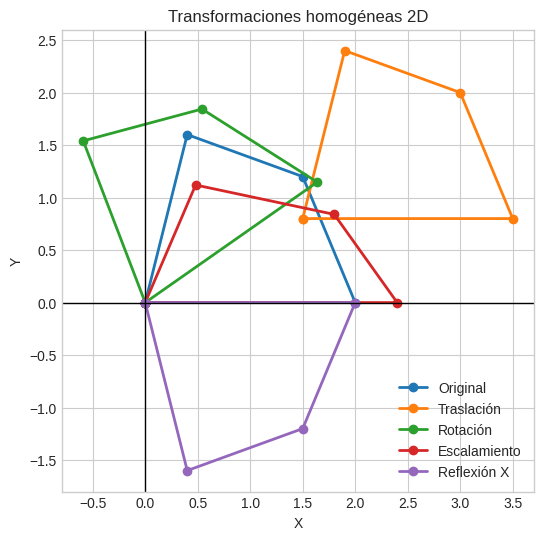

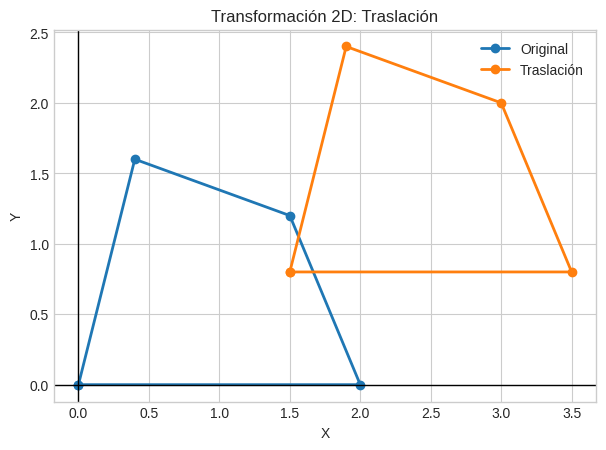

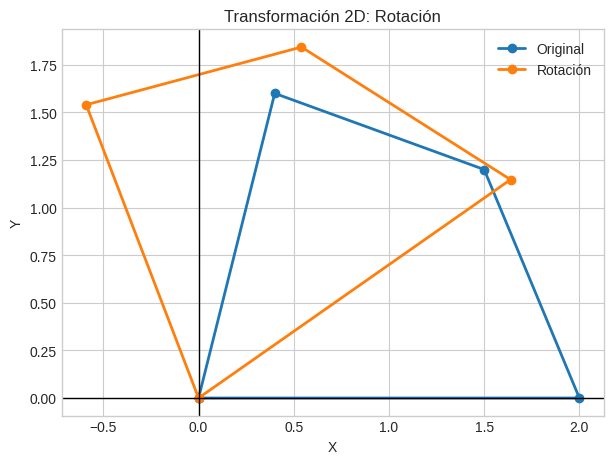

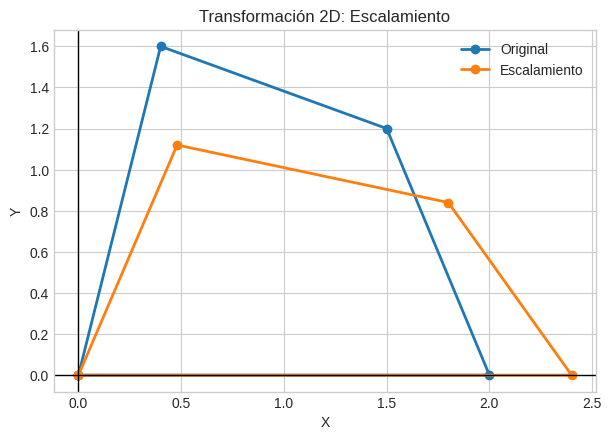

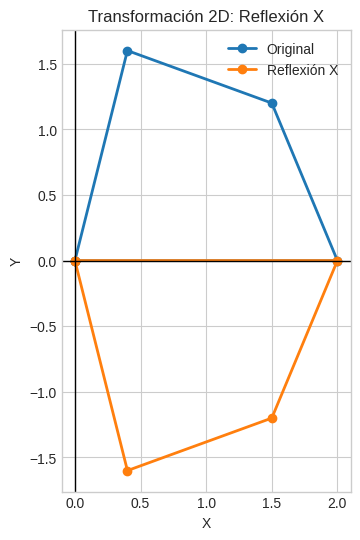

In [4]:
shape_2d = np.array([[0.0, 0.0], [2.0, 0.0], [1.5, 1.2], [0.4, 1.6]])
t2d = translation_2d(1.5, 0.8)
r2d = rotation_2d(np.deg2rad(35))
s2d = scaling_2d(1.2, 0.7)
f2d = reflection_2d('x')

shape_t = apply_transform_2d(shape_2d, t2d)
shape_r = apply_transform_2d(shape_2d, r2d)
shape_s = apply_transform_2d(shape_2d, s2d)
shape_f = apply_transform_2d(shape_2d, f2d)

plot_2d_sets(
    [shape_2d, shape_t, shape_r, shape_s, shape_f],
    ['Original', 'Traslación', 'Rotación', 'Escalamiento', 'Reflexión X'],
    'Transformaciones homogéneas 2D',
    save_suffix='2d_comparativa',
)

plot_2d_sets(
    [shape_2d, shape_t],
    ['Original', 'Traslación'],
    'Transformación 2D: Traslación',
    save_suffix='2d_traslacion',
)

plot_2d_sets(
    [shape_2d, shape_r],
    ['Original', 'Rotación'],
    'Transformación 2D: Rotación',
    save_suffix='2d_rotacion',
)

plot_2d_sets(
    [shape_2d, shape_s],
    ['Original', 'Escalamiento'],
    'Transformación 2D: Escalamiento',
    save_suffix='2d_escalamiento',
)

plot_2d_sets(
    [shape_2d, shape_f],
    ['Original', 'Reflexión X'],
    'Transformación 2D: Reflexión X',
    save_suffix='2d_reflexion_x',
)

## 2) Composición de transformaciones

¿A @ B == B @ A? False
Composición validada: True


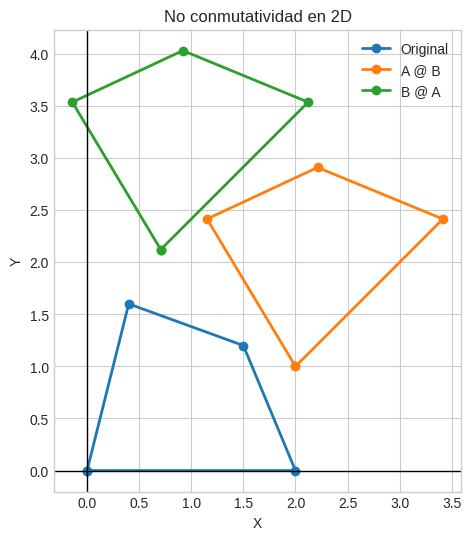

In [5]:
A = translation_2d(2.0, 1.0)
B = rotation_2d(np.deg2rad(45))

T_ab = A @ B
T_ba = B @ A

shape_ab = apply_transform_2d(shape_2d, T_ab)
shape_ba = apply_transform_2d(shape_2d, T_ba)
shape_seq = apply_transform_2d(apply_transform_2d(shape_2d, B), A)

assert np.allclose(shape_ab, shape_seq)
print('¿A @ B == B @ A?', np.allclose(T_ab, T_ba))
print('Composición validada:', np.allclose(shape_ab, shape_seq))

plot_2d_sets(
    [shape_2d, shape_ab, shape_ba],
    ['Original', 'A @ B', 'B @ A'],
    'No conmutatividad en 2D',
    save_suffix='2d_no_conmutatividad',
)

## 3) Coordenadas homogéneas en 3D

In [6]:
def to_homogeneous_3d(points: np.ndarray) -> np.ndarray:
    points = np.asarray(points, dtype=float)
    if points.ndim != 2 or points.shape[1] != 3:
        raise ValueError('Se esperaba un arreglo de forma (N, 3).')
    return np.hstack([points, np.ones((points.shape[0], 1), dtype=float)])


def from_homogeneous_3d(points_h: np.ndarray) -> np.ndarray:
    points_h = np.asarray(points_h, dtype=float)
    if points_h.ndim != 2 or points_h.shape[1] != 4:
        raise ValueError('Se esperaba un arreglo de forma (N, 4).')
    w = points_h[:, [3]]
    if np.any(np.isclose(w, 0.0)):
        raise ValueError('No se puede dividir por w=0.')
    return points_h[:, :3] / w


def translation_3d(tx: float, ty: float, tz: float) -> np.ndarray:
    return np.array([[1.0, 0.0, 0.0, tx], [0.0, 1.0, 0.0, ty], [0.0, 0.0, 1.0, tz], [0.0, 0.0, 0.0, 1.0]])


def scaling_3d(sx: float, sy: float, sz: float) -> np.ndarray:
    return np.array([[sx, 0.0, 0.0, 0.0], [0.0, sy, 0.0, 0.0], [0.0, 0.0, sz, 0.0], [0.0, 0.0, 0.0, 1.0]])


def rotation_x(theta_rad: float) -> np.ndarray:
    c, s = np.cos(theta_rad), np.sin(theta_rad)
    return np.array([[1.0, 0.0, 0.0, 0.0], [0.0, c, -s, 0.0], [0.0, s, c, 0.0], [0.0, 0.0, 0.0, 1.0]])


def rotation_y(theta_rad: float) -> np.ndarray:
    c, s = np.cos(theta_rad), np.sin(theta_rad)
    return np.array([[c, 0.0, s, 0.0], [0.0, 1.0, 0.0, 0.0], [-s, 0.0, c, 0.0], [0.0, 0.0, 0.0, 1.0]])


def rotation_z(theta_rad: float) -> np.ndarray:
    c, s = np.cos(theta_rad), np.sin(theta_rad)
    return np.array([[c, -s, 0.0, 0.0], [s, c, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]])


def reflection_3d(plane: str = 'xy') -> np.ndarray:
    if plane == 'xy':
        return np.diag([1.0, 1.0, -1.0, 1.0])
    if plane == 'xz':
        return np.diag([1.0, -1.0, 1.0, 1.0])
    if plane == 'yz':
        return np.diag([-1.0, 1.0, 1.0, 1.0])
    raise ValueError("plane debe ser 'xy', 'xz' o 'yz'.")


def apply_transform_3d(points: np.ndarray, transform: np.ndarray) -> np.ndarray:
    points_h = to_homogeneous_3d(points)
    transformed_h = (transform @ points_h.T).T
    return from_homogeneous_3d(transformed_h)


def make_unit_cube() -> np.ndarray:
    return np.array([
        [0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
        [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1],
    ], dtype=float)


def plot_cube(ax: plt.Axes, vertices: np.ndarray, title: str, color: str) -> None:
    edges = [(0, 1), (1, 2), (2, 3), (3, 0), (4, 5), (5, 6), (6, 7), (7, 4), (0, 4), (1, 5), (2, 6), (3, 7)]
    for i, j in edges:
        xs, ys, zs = zip(vertices[i], vertices[j])
        ax.plot(xs, ys, zs, color=color, linewidth=2)
    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], color=color, s=30)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

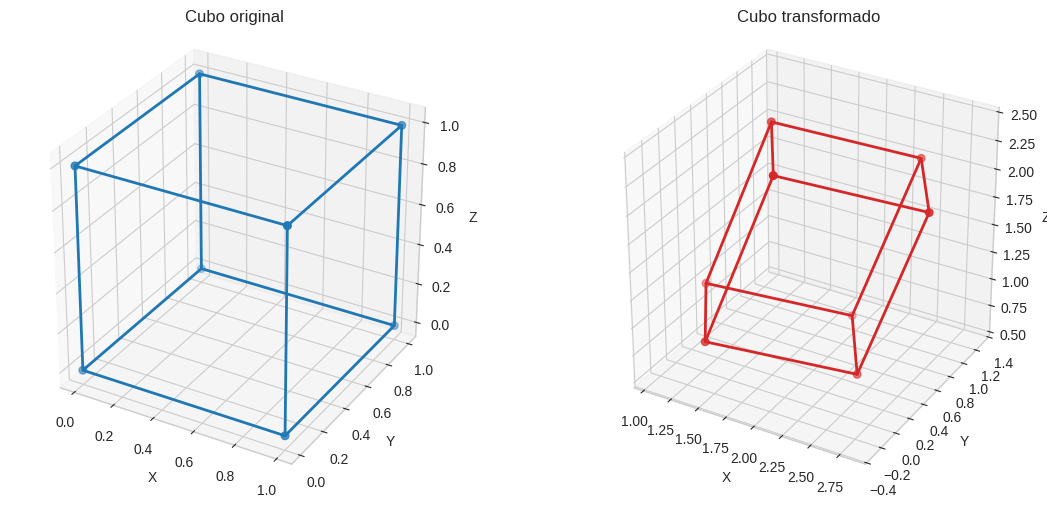

In [7]:
cube = make_unit_cube()
T3D = translation_3d(1.5, -0.3, 1.0) @ rotation_z(np.deg2rad(35)) @ rotation_y(np.deg2rad(20)) @ scaling_3d(1.2, 0.8, 1.5)
cube_transformed = apply_transform_3d(cube, T3D)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
plot_cube(ax1, cube, 'Cubo original', 'tab:blue')
plot_cube(ax2, cube_transformed, 'Cubo transformado', 'tab:red')
for ax in [ax1, ax2]:
    ax.set_box_aspect((1, 1, 1))
plt.tight_layout()
save_figure(fig, '3d_cubo_transformado')
plt.show()

## 4) Cambios de base

¿Coinciden ambos cálculos? True


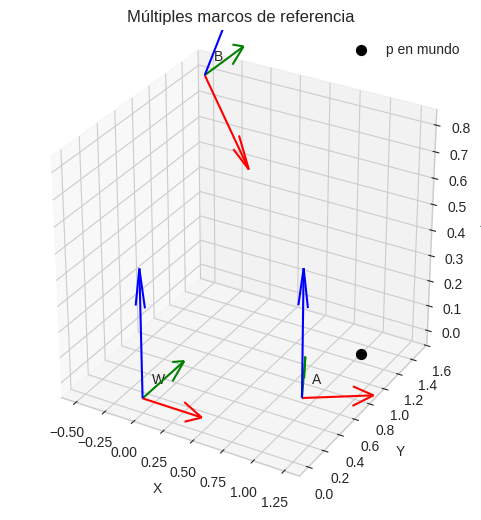

In [8]:
def world_to_local(points_world: np.ndarray, T_local_to_world: np.ndarray) -> np.ndarray:
    return apply_transform_3d(points_world, np.linalg.inv(T_local_to_world))


def draw_frame(ax: plt.Axes, T: np.ndarray, name: str, axis_len: float = 0.5) -> None:
    origin = T[:3, 3]
    ax.quiver(*origin, *(T[:3, 0] * axis_len), color='r')
    ax.quiver(*origin, *(T[:3, 1] * axis_len), color='g')
    ax.quiver(*origin, *(T[:3, 2] * axis_len), color='b')
    ax.text(*(origin + 0.05), name)


T_A_to_W = translation_3d(1.0, 0.5, 0.0) @ rotation_z(np.deg2rad(30))
T_B_to_W = translation_3d(-0.5, 1.5, 0.8) @ rotation_y(np.deg2rad(40))

p_A = np.array([[0.4, 0.2, 0.1]])
p_W = apply_transform_3d(p_A, T_A_to_W)
p_B = world_to_local(p_W, T_B_to_W)
T_A_to_B = np.linalg.inv(T_B_to_W) @ T_A_to_W
p_B_direct = apply_transform_3d(p_A, T_A_to_B)

print('¿Coinciden ambos cálculos?', np.allclose(p_B, p_B_direct))

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
draw_frame(ax, np.eye(4), 'W')
draw_frame(ax, T_A_to_W, 'A')
draw_frame(ax, T_B_to_W, 'B')
ax.scatter(*p_W.ravel(), color='k', s=50, label='p en mundo')
ax.set_title('Múltiples marcos de referencia')
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_box_aspect((1, 1, 1))
ax.legend()
save_figure(fig, '3d_cambios_base')
plt.show()

## 5) Transformaciones inversas

In [9]:
T = translation_3d(2.0, -1.0, 0.5) @ rotation_x(np.deg2rad(25)) @ scaling_3d(1.0, 2.0, 0.5)
T_inv = np.linalg.inv(T)
print('T @ T_inv ≈ I ->', np.allclose(T @ T_inv, np.eye(4)))

sample_points = np.array([[1.0, 2.0, 3.0], [-1.0, 0.5, 2.2]])
transformed = apply_transform_3d(sample_points, T)
recovered = apply_transform_3d(transformed, T_inv)
print('¿Se recuperan correctamente?', np.allclose(sample_points, recovered))

T @ T_inv ≈ I -> True
¿Se recuperan correctamente? True


## 6) Aplicación en robótica: cinemática directa

Posición del efector final: [2.7501 1.8004 0.    ]


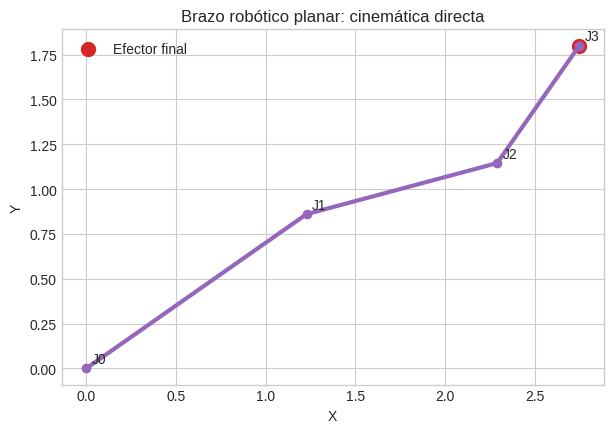

In [10]:
def dh_planar(theta: float, link_length: float) -> np.ndarray:
    return rotation_z(theta) @ translation_3d(link_length, 0.0, 0.0)


def forward_kinematics_planar(joint_angles_rad: np.ndarray, link_lengths: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    if len(joint_angles_rad) != len(link_lengths):
        raise ValueError('joint_angles_rad y link_lengths deben tener misma longitud.')

    T = np.eye(4)
    joint_positions = [np.array([0.0, 0.0, 0.0])]
    for theta, length in zip(joint_angles_rad, link_lengths):
        T = T @ dh_planar(theta, length)
        joint_positions.append(T[:3, 3].copy())
    return T, np.vstack(joint_positions)


angles_rad = np.deg2rad(np.array([35.0, -20.0, 40.0]))
links = np.array([1.5, 1.1, 0.8])
T_end, joints = forward_kinematics_planar(angles_rad, links)
print('Posición del efector final:', T_end[:3, 3])

fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(joints[:, 0], joints[:, 1], '-o', linewidth=3, color='tab:purple')
ax.scatter(joints[-1, 0], joints[-1, 1], color='tab:red', s=100, label='Efector final')
for i, (x, y, _) in enumerate(joints):
    ax.text(x + 0.03, y + 0.03, f'J{i}')
ax.set_title('Brazo robótico planar: cinemática directa')
ax.set_xlabel('X'); ax.set_ylabel('Y')
ax.set_aspect('equal', adjustable='box')
ax.legend()
save_figure(fig, 'robotica_cinematica_directa')
plt.show()

n_frames = 120
t = np.linspace(0.0, 2.0 * np.pi, n_frames)
angles_deg_traj = np.column_stack([
    35.0 + 25.0 * np.sin(t),
    -20.0 + 20.0 * np.sin(t + np.pi / 3.0),
    40.0 + 30.0 * np.sin(t + 2.0 * np.pi / 3.0),
])

fig_anim, ax_anim = plt.subplots(figsize=(7, 6))
line, = ax_anim.plot([], [], '-o', linewidth=3, color='tab:purple')
ee_point = ax_anim.scatter([], [], color='tab:red', s=100, label='Efector final')
frame_text = ax_anim.text(0.02, 0.95, '', transform=ax_anim.transAxes)

max_reach = links.sum() + 0.2
ax_anim.set_xlim(-max_reach, max_reach)
ax_anim.set_ylim(-max_reach, max_reach)
ax_anim.set_title('Brazo robótico planar: animación')
ax_anim.set_xlabel('X'); ax_anim.set_ylabel('Y')
ax_anim.set_aspect('equal', adjustable='box')
ax_anim.legend()


def init_animation():
    line.set_data([], [])
    ee_point.set_offsets(np.empty((0, 2)))
    frame_text.set_text('')
    return line, ee_point, frame_text


def update_animation(frame: int):
    angles_frame = np.deg2rad(angles_deg_traj[frame])
    _, joints_frame = forward_kinematics_planar(angles_frame, links)
    line.set_data(joints_frame[:, 0], joints_frame[:, 1])
    ee_point.set_offsets(joints_frame[-1, :2])
    frame_text.set_text(f'Frame: {frame + 1}/{n_frames}')
    return line, ee_point, frame_text


anim = FuncAnimation(
    fig_anim,
    update_animation,
    frames=n_frames,
    init_func=init_animation,
    interval=60,
    blit=False,
    repeat=True,
    )

anim.save(
    MEDIA_DIR / 'python_robotica_cinematica_directa.gif',
    writer=PillowWriter(fps=20),
    )

display(HTML(anim.to_jshtml()))
plt.close(fig_anim)